# LOAD DATASET

We will be using tensorflow's dataset API. It allows us to create data pipelines. Rather than loading everything into memory, it allows us to create a data pipeline thereby helping us to scale to larger datasets and also gives us a repitible set of steps. Rather than using it directly we will be using it via a keras utility. 

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import imghdr
import tensorflow as tf

In [4]:
# As stated earlier we will be using the tensorflow API via the keras helper which would allow us to automatically create
# a dataset from our images. Images would get automatically labelled. 

data = tf.keras.utils.image_dataset_from_directory("F:\Data copy 1\
                                                    Digital images of defective and good condition tyres", 
                                                   image_size = (300, 300), shuffle = True)

Found 1856 files belonging to 2 classes.


The drawback of using this dataset API is that it does not allow us to iterate over the dataset.  So, we will convert it to a numpy iterator. 

In [5]:
data_iterator = data.as_numpy_iterator()

Data iterator automatically creates batches of our data. We can access these batches one by one. 

In [6]:
batch = data_iterator.next()

In [7]:
# The variable batch returns a tuple with a set number of images and their corresponding labels (1 or 0 or more).
batch[0].shape
# This shows that the first batch has 32 images of size 256*256*3. The default setting for the dataset API is 256*256 
# so every image has been resized.

(32, 300, 300, 3)

In [8]:
# This shows the corresponding labels to every image in the given batch
batch[1]

array([1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0])

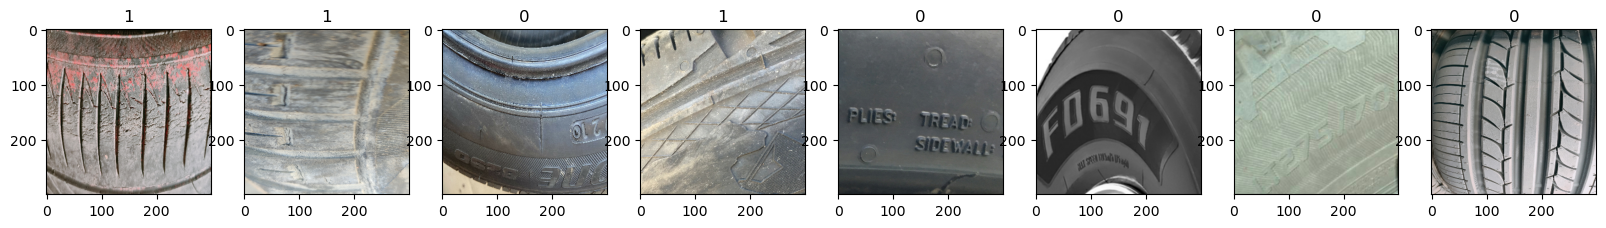

In [9]:
# Let us plot the batch
fig, ax = plt.subplots(ncols = 8, figsize = (20, 20))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

From visual inspection we can see that 1 refers to non defective (or good) tyres and zero refers to defective tyres

tf.Tensor(1, shape=(), dtype=int32)


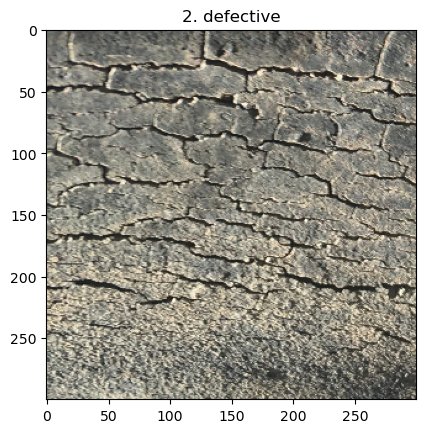

In [10]:
for image_batch, label_batch in data.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.title(data.class_names[label_batch[0]])
    print(label_batch[0])

# PREPROCESSING DATA

In [13]:
data = data.map(lambda x, y: (x/255, y))

SPLIT DATA

In [15]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)

In [16]:
train_size, val_size, test_size

(40, 11, 5)

In [17]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# MODEL BUILDING

In [18]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [19]:
model = Sequential()

# Convolutional layers
model.add(Conv2D(128, (3,3),activation = 'relu', input_shape = (300, 300, 3), 
                 kernel_initializer=keras.initializers.HeUniform()))
model.add(keras.layers.BatchNormalization())
model.add(MaxPooling2D(pool_size = (3,3)))
#He uniform because we are using relu activation function

model.add(Conv2D(128, (3,3), activation = 'relu',
                 kernel_initializer=keras.initializers.HeUniform()))
model.add(keras.layers.BatchNormalization())
model.add(MaxPooling2D(pool_size = (3,3)))

model.add(Conv2D(128, (3,3),activation = 'relu', 
                 kernel_initializer=keras.initializers.HeUniform()))
model.add(keras.layers.BatchNormalization())
model.add(MaxPooling2D(3,3))


# Fully connected layers
model.add(Flatten())
model.add(Dense(64, activation = 'relu', 
                kernel_initializer=keras.initializers.HeUniform()))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

# Compile the model

model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

C:\Users\ADMINN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 298, 298, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 298, 298, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 97, 97, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       819,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,119,617 (4.27 MB)

 Trainable params: 1,118,849 (4.27 MB)

 Non-trainable params: 768 (3.00 KB)

In [21]:
filepath = r"F:/BestCNNModels NR/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath, monitor = 'val_accuracy', mode = 'max', 
                                                save_best_only = True, verbose = 1)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 8, restore_best_weights = True)

In [22]:
model.fit(train,  epochs = 50, validation_data = val, callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6015 - loss: 1.4039
Epoch 1: val_accuracy improved from -inf to 0.59659, saving model to F:/BestCNNModels NR/weights-improvement-01-0.60.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 232s 6s/step - accuracy: 0.6022 - loss: 1.3925 - val_accuracy: 0.5966 - val_loss: 0.6687
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6974 - loss: 0.5938
Epoch 2: val_accuracy did not improve from 0.59659
40/40 ━━━━━━━━━━━━━━━━━━━━ 226s 6s/step - accuracy: 0.6976 - loss: 0.5934 - val_accuracy: 0.5142 - val_loss: 0.7361
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7404 - loss: 0.5045
Epoch 3: val_accuracy did not improve from 0.59659
40/40 ━━━━━━━━━━━━━━━━━━━━ 228s 6s/step - accuracy: 0.7403 - loss: 0.5048 - val_accuracy: 0.4233 - val_loss: 0.8816
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7781 - loss: 0.4666
Epoch 4: val_accuracy did not improve from 0.59659
40/40 ━━━━━━━━━━━━━━━━━━━━ 229s 6s/step - ac

Epoch 25/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9788 - loss: 0.0691
Epoch 25: val_accuracy did not improve from 0.92898
40/40 ━━━━━━━━━━━━━━━━━━━━ 239s 6s/step - accuracy: 0.9787 - loss: 0.0693 - val_accuracy: 0.9006 - val_loss: 0.2721
Epoch 26/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9674 - loss: 0.0803
Epoch 26: val_accuracy improved from 0.92898 to 0.94318, saving model to F:/BestCNNModels NR/weights-improvement-26-0.94.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 231s 6s/step - accuracy: 0.9676 - loss: 0.0802 - val_accuracy: 0.9432 - val_loss: 0.1544
Epoch 27/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9667 - loss: 0.0767
Epoch 27: val_accuracy did not improve from 0.94318
40/40 ━━━━━━━━━━━━━━━━━━━━ 231s 6s/step - accuracy: 0.9667 - loss: 0.0769 - val_accuracy: 0.8892 - val_loss: 0.3367
Epoch 28/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9854 - loss: 0.0490
Epoch 28: val_accuracy did not improve from 0.94318
40/40 ━━━━━━━━━━━━━━━━━━━━ 236s 6

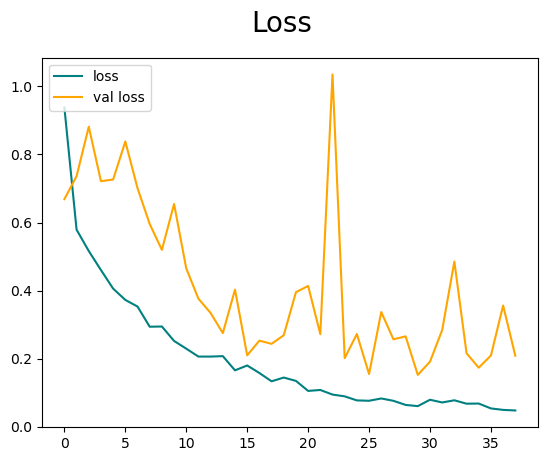

In [23]:
fig = plt.figure()
plt.plot(model.history.history['loss'], color = 'teal', label = 'loss')
plt.plot(model.history.history['val_loss'], color = 'orange', label = 'val loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

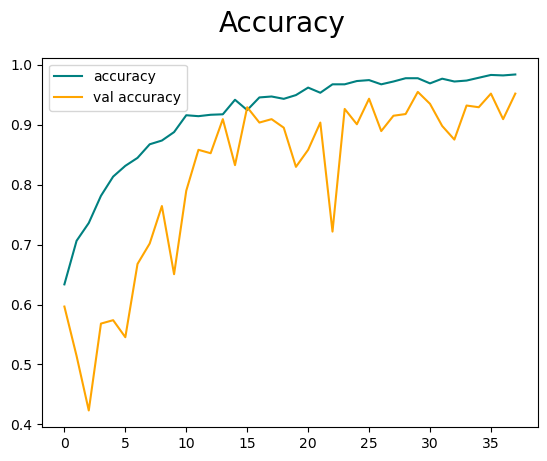

In [24]:
fig = plt.figure()
plt.plot(model.history.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(model.history.history['val_accuracy'], color = 'orange', label = 'val accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

# EVALUATING THE MODEL

In [25]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average

In [43]:
final_model = load_model("F:\BestCNNModels NR\weights-improvement-30-0.95.keras")

In [27]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [28]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [31]:
for batch in test.as_numpy_iterator():
    X, y = batch # Since test is a tuple with 5 batches we are unpacking it in the form of X and y
    yhat = model.predict(X) # Make prediction for the given batch
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


In [32]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.9473684430122375, Recall:0.9775280952453613, Accuracy:0.949999988079071


The metrics are quite good as we can see. Let us try to improve the model using data augmentation, that way our model would be able to generalise better, but we would not train it from scratch rather we will use our best model from previous training and re run it on new data. The target would be to beat 95% validation accuracy.

In [34]:
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
input_folder = "F:\Data copy 1\Digital images of defective and good condition tyres"
output = "F:\Split_data"
splitfolders.fixed(input_folder,
                   output = output,
                   seed = 42,
                  fixed = (206, 104),
                  oversample = True, # we are using oversampling because the classes are imbalanced 
                  group_prefix = None)

Copying files: 1856 files [01:27, 21.26 files/s]
Oversampling: 2 classes [00:01,  1.84 classes/s]


# DATA AUGMENTATION

In [44]:
batch_size = 32

# This is the augmentation configuration we will be using for training
train_datagen = ImageDataGenerator(rescale = 1./255,
                           rotation_range = 0.2,
                          zoom_range = 0.2,
                          horizontal_flip = True,
                          width_shift_range = 0.2)

# This is the augmentation configuration we will be using for validation  
# We are simply rescaling the data
val_datagen = ImageDataGenerator(rescale = 1./255)


train_generator = train_datagen.flow_from_directory(
                r"F:\Split_data\train", # This is the target directory
                target_size = (300, 300), # All images will be resized to 228*228
                batch_size = batch_size,
                class_mode = 'binary') # Since we are using binary_cross_entropy

val_generator = val_datagen.flow_from_directory(
                r"F:\Split_data\val", # thios is the target directory
                target_size = (300, 300),
                batch_size = batch_size,
                class_mode = 'binary')

Found 1436 images belonging to 2 classes.
Found 412 images belonging to 2 classes.


In [45]:
filepath = r"F:/BestCNNModels Retrained/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath, monitor = 'val_accuracy', mode = 'max', save_best_only = True, verbose = 1)

In [46]:
tf.config.run_functions_eagerly(True)

In [47]:
final_model.fit(train_generator,  epochs = 50, validation_data = val_generator, callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7687 - loss: 0.5923
Epoch 1: val_accuracy improved from -inf to 0.92233, saving model to F:/BestCNNModels Retrained/weights-improvement-01-0.92.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 392s 8s/step - accuracy: 0.7689 - loss: 0.5910 - val_accuracy: 0.9223 - val_loss: 0.2087
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7761 - loss: 0.4799
Epoch 2: val_accuracy did not improve from 0.92233
45/45 ━━━━━━━━━━━━━━━━━━━━ 387s 8s/step - accuracy: 0.7763 - loss: 0.4795 - val_accuracy: 0.8714 - val_loss: 0.3090
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8227 - loss: 0.4114
Epoch 3: val_accuracy did not improve from 0.92233
45/45 ━━━━━━━━━━━━━━━━━━━━ 375s 8s/step - accuracy: 0.8227 - loss: 0.4112 - val_accuracy: 0.9175 - val_loss: 0.2313
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8447 - loss: 0.3574
Epoch 4: val_accuracy did not improve from 0.92233
45/45 ━━━━━━━━━━━━━━━━━━━━ 378s 8s/st

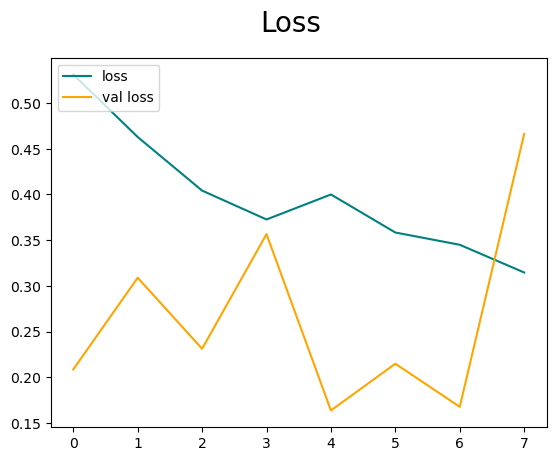

In [48]:
fig = plt.figure()
plt.plot(final_model.history.history['loss'], color = 'teal', label = 'loss')
plt.plot(final_model.history.history['val_loss'], color = 'orange', label = 'val loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

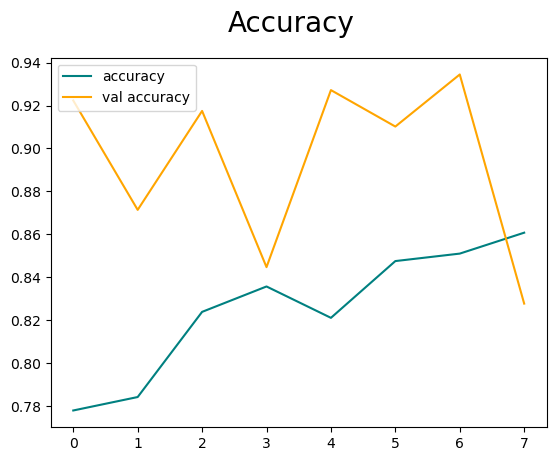

In [49]:
fig = plt.figure()
plt.plot(final_model.history.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(final_model.history.history['val_accuracy'], color = 'orange', label = 'val accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

By running the model on 50 epochs again, the accuracy of the best model came out to be 93% that too in just 8 epochs. The loss in accuracy is not surprising because the model is being trained on far more different images than earlier. The early callback kicked in which halted the training. So, even though  the model’s accuracy is lesser than earlier this one is likely to generalize better on new data. 